In [1]:
#Installation of relevant libraries
!pip install datasets
!pip install --upgrade transformers accelerate
!pip install rouge-score
!pip install rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-

In [2]:
#Importing relevant libraries
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from rouge_score import rouge_scorer
import pandas as pd
import random

In [3]:
# Loading the T5-based model and tokenizer
fal_model = AutoModelForSeq2SeqLM.from_pretrained('Falconsai/text_summarization')
tokenizer = AutoTokenizer.from_pretrained('Falconsai/text_summarization')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [4]:
#Loading dataset from huggingface transformer
dataset = load_dataset('multi_news')

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

In [5]:
#Checking the structure and composition of the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
})


EXPLORATORY DATA ANALYSIS

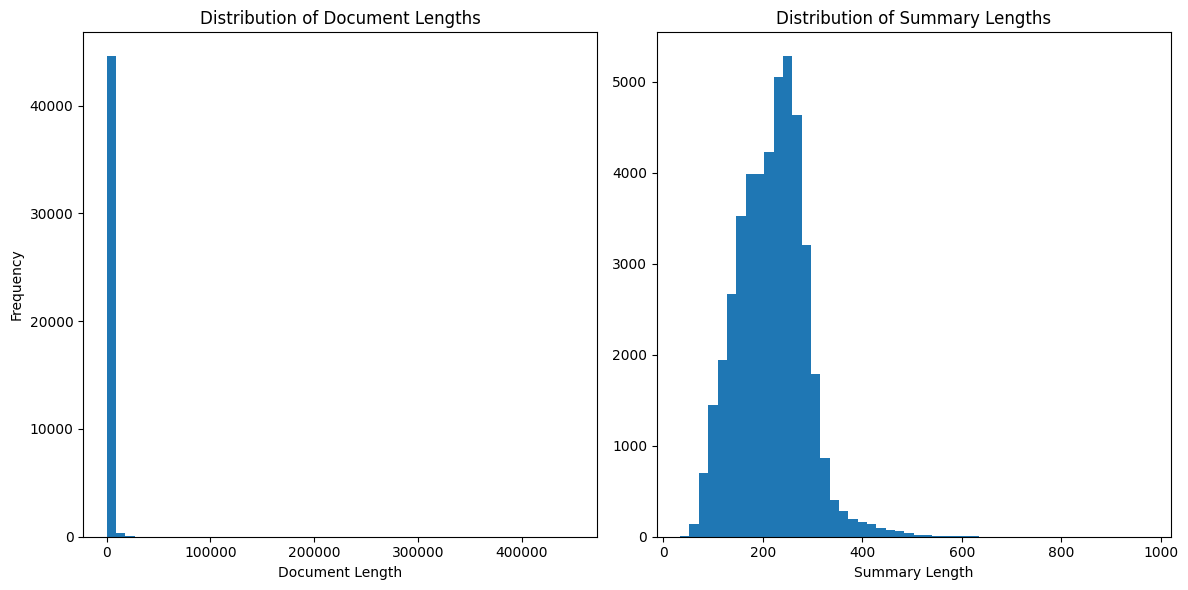

In [6]:
# Calculate the length of the documents and summaries
document_lengths = [len(doc.split()) for doc in dataset['train']['document']]
summary_lengths = [len(summary.split()) for summary in dataset['train']['summary']]

# Plot the distribution of document lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(document_lengths, bins=50)
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')

# Plot the distribution of summary lengths
plt.subplot(1, 2, 2)
plt.hist(summary_lengths, bins=50)
plt.xlabel('Summary Length')
plt.title('Distribution of Summary Lengths')

plt.tight_layout()
plt.show()

In [7]:
def calculate_overlap(document, summary):
    """
    Function to calculate the overlap between a document and its summary.

    Parameters:
    document (str): The document text.
    summary (str): The summary text.

    Returns:
    float: The overlap between the document and the summary as a fraction of the total number of words in the summary.
    """
    document_words = set(document.split())
    summary_words = set(summary.split())
    overlap = summary_words.intersection(document_words)
    return len(overlap) / len(summary_words)

# Calculate the overlap for each example in the training dataset
overlaps = [calculate_overlap(doc, summary) for doc, summary in zip(dataset['train']['document'], dataset['train']['summary'])]

# Calculate and print the average overlap
average_overlap = sum(overlaps) / len(overlaps)
print(f'Average overlap between documents and summaries: {average_overlap * 100:.2f}%')

Average overlap between documents and summaries: 60.97%


**DATA PREPARATION**

In [8]:
def summarize_text(input_text, model):
    """
    Function to generate a summary for a given input text using a specified model.

    Parameters:
    input_text (str): The text to be summarized.
    model (transformers.PreTrainedModel): The model to be used for summarization.

    Returns:
    str: The generated summary.
    """
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(model.device)
    summary_tokens = model.generate(input_ids, min_length=30, max_length=200)
    generated_summary = tokenizer.decode(summary_tokens[0], skip_special_tokens=True)
    return generated_summary

# Fetch the test dataset
test_dataset = dataset['test']

# Randomly select 5 indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 1)

for index in random_indices:
    # Fetch a document and its corresponding summary from the test dataset
    extracted_document = test_dataset[index]['document']
    extracted_summary = test_dataset[index]['summary']

    # Generate a summary for the extracted document
    created_summary = summarize_text(extracted_document, model=fal_model)

    # Print the original document, the original summary, and the generated summary
    print("Extracted Document:")
    print(extracted_document)
    print("\n Extracted Summary:")
    print(extracted_summary)
    print("\n Created Summary:")
    print(created_summary)
    print("\n---\n")

Token indices sequence length is longer than the specified maximum sequence length for this model (1871 > 512). Running this sequence through the model will result in indexing errors


Extracted Document:
Scientists say they are well on the way to resurrecting an ancient species of super-cow revered by the Nazis after it went extinct nearly 400 years ago. 
 
 The auroch roamed the grassy plains of Europe for 250,000 years until it died out in Poland in 1627, and Adolf Hitler's followers tried to breed a similar beast as part of their Aryan mythology. 
 
 Now conservationists who believe the bovine ancestor was key to preserving the continent's ecosystem have said they are 'rewilding' the fourth generation of their experimental auroch replacement as part of the Tauros Project. 
 
 Founder and ecologist Ronald Goderie told CNN: "We thought we needed a grazer that is fully self-sufficient in case of big predators...and could do the job of grazing big wild areas. We reasoned that this animal would have to resemble an auroch. 
 
 "We see progress not only in looks and behavior but also in de-domestication of the animals." 
 
 In conjunction with the Rewilding Europe group

In [9]:
#Tokenization of the data
def tokenize_data(data):
    """
    Function to tokenize the document and summary data.

    Parameters:
    data (dict): A dictionary containing 'document' and 'summary' keys.

    Returns:
    dict: A dictionary containing tokenized 'input_ids', 'attention_mask', and 'labels'.
    """
    inputs = tokenizer(data['document'], truncation=True, max_length=512, padding='max_length')
    outputs = tokenizer(data['summary'], truncation=True, max_length=128, padding='max_length')
    return {
        'input_ids': inputs.input_ids,
        'attention_mask': inputs.attention_mask,
        'labels': outputs.input_ids
    }

train_dataset = dataset['train'].map(tokenize_data, batched=True)
val_dataset = dataset['validation'].map(tokenize_data, batched=True)

Map:   0%|          | 0/44972 [00:00<?, ? examples/s]

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

**FINE TUNNING OF PRE-TRAINNED MODEL**

In [10]:
#Creating fine tunning parameters
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.001,
    logging_dir='./logs',
    evaluation_strategy='steps',
    eval_steps=500,
)

# Create the Trainer and train
trainer = Trainer(
    model=fal_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

train_state = trainer.train()

Step,Training Loss,Validation Loss
500,3.474200,3.001854
1000,3.188700,2.910746
1500,3.124200,2.881111
2000,3.115100,2.860953
2500,3.086400,2.845591
3000,3.060200,2.834929
3500,3.050100,2.826103
4000,3.041500,2.819648
4500,3.035100,2.815018
5000,3.030100,2.809521


In [11]:
#saving fine-tunned model
trainer.save_model("C:\\Users\\franc\\OneDrive\\Desktop\\summarization\\news_model2")

In [12]:
# Load the fine-tuned model from the directory
model2 = AutoModelForSeq2SeqLM.from_pretrained("C:\\Users\\franc\\OneDrive\\Desktop\\summarization\\news_model2")



In [13]:
#Evaluting fine-tunned model
eval_result = trainer.evaluate(eval_dataset=val_dataset)
print(eval_result)

{'eval_loss': 2.793719530105591, 'eval_runtime': 85.0561, 'eval_samples_per_second': 66.098, 'eval_steps_per_second': 4.138, 'epoch': 2.0}


In [15]:
# testing fine-tunned model on the test dataset
# Load the fine-tuned model
model2 = AutoModelForSeq2SeqLM.from_pretrained("C:\\Users\\franc\\OneDrive\\Desktop\\summarization\\news_model2")

# Fetch the test dataset
test_dataset = dataset['test']

# Randomly select 1 indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 1)

for index in random_indices:
    # Fetch a document and its corresponding summary from the test dataset
    extracted_document = test_dataset[index]['document']
    extracted_summary = test_dataset[index]['summary']

    # Generate a summary for the extracted document
    created_summary = summarize_text(extracted_document, model=model2)

    # Print the original document, the original summary, and the generated summary
    print("Extracted Document:")
    print(extracted_document)
    print("\nExtracted Summary:")
    print(extracted_summary)
    print("\nCreated Summary:")
    print(created_summary)
    print("\n---\n")

Extracted Document:
A volunteer for Ben Carson's Republican presidential campaign died Tuesday after a van carrying four staff members flipped over on a patch of ice in Cass County, Iowa, and was rammed by another vehicle, hospital officials confirmed Tuesday night. 
 
 Play Facebook 
 
 Twitter 
 
 Embed Ben Carson volunteer killed when campaign van crashes in Iowa 0:28 autoplay autoplay Copy this code to your website or blog 
 
 Carson immediately suspended his campaign for at least two days to travel from South Carolina to Omaha, Nebraska, where Braden Joplin, 25, was rushed for treatment at the University of Nebraska Medical Center, the campaign said. 
 
 Joplin died at 4:30 p.m. (5:30 p.m. ET), the hospital said. The other passengers — Drew McCall, a field director for the campaign, and volunteers Aaron Ohnemus and Ryan Patrick Shellooe — weren't seriously injured and were released from a local hospital, the campaign said. 
 
 Rest In Peace Braden Joplin. Our thoughts and prayers 

**EVALUATION**

In [19]:
#ROUGE TEST FOR FINE-TUNNED MODEL
from rouge import Rouge

# Fetch the test dataset
test_dataset = dataset['test']

# Randomly select 1 indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 1)

# Lists to store the extracted documents, summaries, and created summaries
extracted_documents = []
extracted_summaries = []
created_summaries = []

for index in random_indices:
    # Fetch a document and its corresponding summary from the test dataset
    extracted_document = test_dataset[index]['document']
    extracted_summary = test_dataset[index]['summary']

    # Generate a summary for the extracted document
    created_summary = summarize_text(extracted_document, model=model2)

    # Add the extracted document, summary, and created summary to the lists
    extracted_documents.append(extracted_document)
    extracted_summaries.append(extracted_summary)
    created_summaries.append(created_summary)

# Create a DataFrame using the lists
df = pd.DataFrame({
    'extracted_document': extracted_documents,
    'extracted_summary': extracted_summaries,
    'created_summary': created_summaries
})


def calculate_rouge_score(row, model_summary):
    rouge1 = Rouge()
    scores1 = rouge1.get_scores(row['created_summary'], row['extracted_summary'], avg=True)
    return scores1

df['model1_rouge_score'] = df.apply(calculate_rouge_score, args=('created_summary',), axis=1)


# Print only the ROUGE scores
for index, row in df.iterrows():
    print(f"Document {index+1} Model 1 ROUGE scores: {row['model1_rouge_score']}")



Document 1 Model 1 ROUGE scores: {'rouge-1': {'r': 0.2047244094488189, 'p': 0.49056603773584906, 'f': 0.28888888473395063}, 'rouge-2': {'r': 0.08333333333333333, 'p': 0.2153846153846154, 'f': 0.12017166979682822}, 'rouge-l': {'r': 0.1889763779527559, 'p': 0.4528301886792453, 'f': 0.26666666251172844}}


In [20]:
# ROUGE TEST FOR PRE-TRAINED MODEL

# Fetch the test dataset
test_dataset = dataset['test']

# Randomly select 1 indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 1)

# Lists to store the extracted documents, summaries, and created summaries
extracted_documents = []
extracted_summaries = []
created_summaries = []

for index in random_indices:
    # Fetch a document and its corresponding summary from the test dataset
    extracted_document = test_dataset[index]['document']
    extracted_summary = test_dataset[index]['summary']

    # Generate a summary for the extracted document
    created_summary = summarize_text(extracted_document, model=fal_model)

    # Add the extracted document, summary, and created summary to the lists
    extracted_documents.append(extracted_document)
    extracted_summaries.append(extracted_summary)
    created_summaries.append(created_summary)

# Create a DataFrame using the lists
df = pd.DataFrame({
    'extracted_document': extracted_documents,
    'extracted_summary': extracted_summaries,
    'created_summary': created_summaries
})


def calculate_rouge_score(row, model_summary):
    rouge2 = Rouge()
    scores2 = rouge2.get_scores(row['created_summary'], row['extracted_summary'], avg=True)
    return scores2

df['model1_rouge_score'] = df.apply(calculate_rouge_score, args=('created_summary',), axis=1)


# Print only the ROUGE scores
for index, row in df.iterrows():
    print(f"Document {index+1} Model 2 ROUGE scores: {row['model1_rouge_score']}")



Document 1 Model 2 ROUGE scores: {'rouge-1': {'r': 0.07317073170731707, 'p': 0.5142857142857142, 'f': 0.1281138768227353}, 'rouge-2': {'r': 0.011142061281337047, 'p': 0.08888888888888889, 'f': 0.019801978218434668}, 'rouge-l': {'r': 0.06910569105691057, 'p': 0.4857142857142857, 'f': 0.12099643910031536}}
